# MachineMax Technical Test

## Imports

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
import re
from tqdm import tqdm
from dataclasses import dataclass
from pykalman import KalmanFilter
from Codebase.utils import TimeSeriesDataGenerator

## Data Generation

In [2]:
# Defining parameters for the time series data
start_date = '2021-01-01 00:00:00'
end_date = '2021-01-01 00:10:00'
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')
freq = '1S'
max_duration = 60

In [3]:
generator = TimeSeriesDataGenerator()
df = generator.generate_time_series_data(start_date, end_date, freq, max_duration)

Generating Data: 100%|████████████████████| 601/601 [00:00<00:00, 300450.14it/s]


### Plotting Data

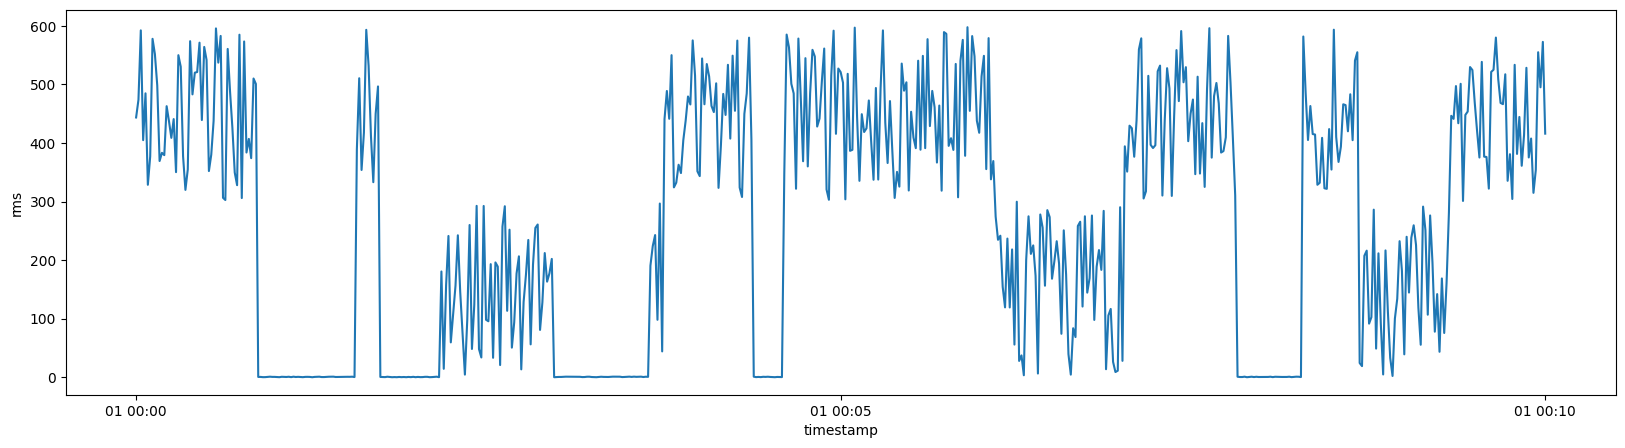

In [4]:
ax, fig = plt.subplots(figsize=(20, 5))
sns.lineplot(x='timestamp', y='rms', data=df, ax=fig)
plt.show()

### Applying Kalman Filter

In [5]:
df.head()

,timestamp,state,rms
0,2021-01-01 00:00:00,ACTIVE,443.612026
1,2021-01-01 00:00:01,ACTIVE,473.752543
2,2021-01-01 00:00:02,ACTIVE,592.390961
3,2021-01-01 00:00:03,ACTIVE,404.896410
4,2021-01-01 00:00:04,ACTIVE,484.840173


In [9]:
# Compare the current state to the previous state
df['state_change'] = df['state'] != df['state'].shift()
# Get the indices where state has changed
change_indices = df[df['state_change']].index.tolist()
change_indices

# Add the starting and ending index to change_indices
change_indices = change_indices + [len(df)]

pairs = [[change_indices[i], change_indices[i+1]] for i in range(len(change_indices)-1)]
# Create a Kalman Filter
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=0,
                  initial_state_covariance=1,
                  observation_covariance=.5,
                  transition_covariance=1)

# Loop over pairs of indices in change_indices
for i, pair in enumerate(pairs):
    # Select the data in the current interval
    interval_data = df['rms'][pair[0]:pair[1]]    
    # Apply the Kalman filter to the data in the current interval
    state_means, state_covariances = kf.em(interval_data).smooth(interval_data)
    # Replace the 'rms' values in the DataFrame with the filtered values
    df.loc[pair[0]:pair[1]-1, 'rms_smoothed'] = state_means.flatten()

0     443.612026
1     473.752543
2     592.390961
3     404.896410
4     484.840173
5     328.654690
6     377.016958
7     577.949382
8     551.837420
9     498.512403
10    369.287190
11    383.230471
12    379.287501
13    462.907154
14    437.248436
15    408.832098
16    440.859552
17    350.246894
18    549.986059
19    530.326252
20    377.286084
21    319.943837
22    354.889172
23    573.910716
24    483.065881
25    520.119604
26    521.221198
27    571.359344
28    439.259548
29    564.069929
30    541.863714
31    352.118966
32    380.143490
33    437.796834
34    595.727884
35    537.279556
36    582.887272
37    306.446429
38    302.642782
39    560.679148
40    487.905739
41    425.858346
42    349.535517
43    327.985974
44    584.971510
45    306.004088
46    573.429784
47    383.789423
48    407.012951
49    374.139991
50    510.161329
51    500.894294
Name: rms, dtype: float64
52    0.490947
53    0.530005
54    0.103408
55    0.175634
56    0.582648
57    0.912269


In [10]:
# Create a Kalman Filter
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=0,
                  initial_state_covariance=1,
                  observation_covariance=.5,
                  transition_covariance=1)

# Use the observations y to get a rolling mean and variance
state_means, state_covariances = kf.em(df['rms_smoothed']).smooth(df['rms_smoothed'])

# Add the smoothed data to the dataframe
df['rms_smoothed_total'] = state_means

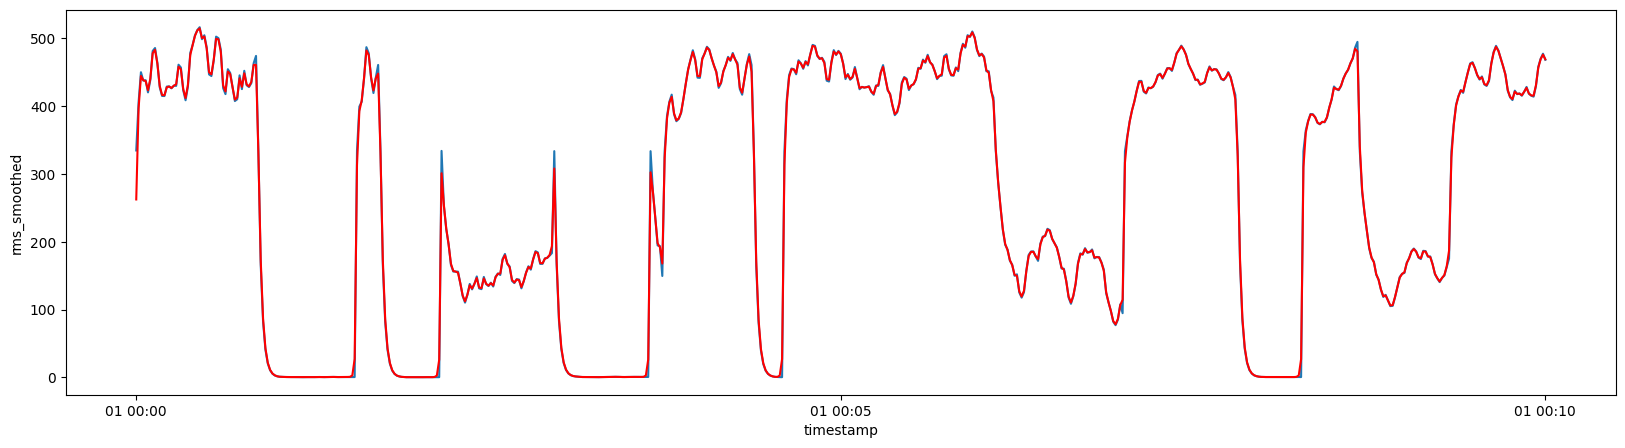

In [11]:
ax, fig = plt.subplots(figsize=(20, 5))
sns.lineplot(x='timestamp', y='rms_smoothed', data=df, ax=fig)
sns.lineplot(x='timestamp', y='rms_smoothed_total', data=df, ax=fig, color='red')
# sns.lineplot(x='timestamp', y='rms', data=df, ax=fig, color='green')
plt.show()